In [2]:
import pandas as pd
import joblib
import shap

# 1. Load the Model
model = joblib.load('best_fraud_model.pkl')

# 2. Load the Data
X_test = pd.read_csv('X_test_for_shap.csv')
y_test = pd.read_csv('y_test_for_shap.csv')

print("Model and Data loaded successfully!")

Model and Data loaded successfully!


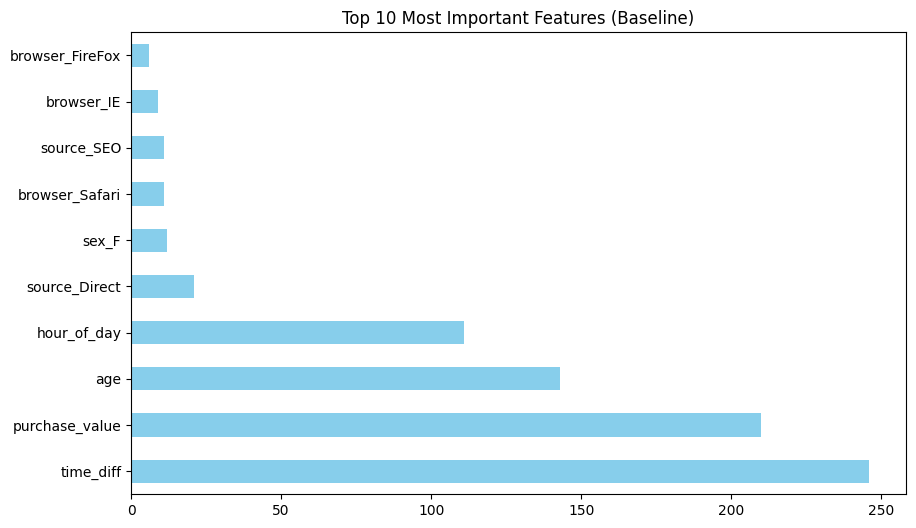

In [3]:
import matplotlib.pyplot as plt

# Built-in Importance Baseline
importances = pd.Series(model.feature_importances_, index=X_test.columns)
top_10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_10.plot(kind='barh', color='skyblue')
plt.title('Top 10 Most Important Features (Baseline)')
plt.show()

In [5]:
# 1. Get the model's predictions
y_pred = model.predict(X_test)

# 2. Create a table to compare actual vs predicted
# (Make sure y_test is a flat series)
results = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred})

# 3. Safely find the indices
try:
    tp_idx = results[(results['Actual'] == 1) & (results['Predicted'] == 1)].index[0]
    print(f"True Positive Row: {tp_idx}")
except IndexError:
    tp_idx = None
    print("No True Positives found.")

try:
    fp_idx = results[(results['Actual'] == 0) & (results['Predicted'] == 1)].index[0]
    print(f"False Positive Row: {fp_idx}")
except IndexError:
    fp_idx = None
    print("No False Positives found (The model is perfectly precise!).")

try:
    fn_idx = results[(results['Actual'] == 1) & (results['Predicted'] == 0)].index[0]
    print(f"False Negative Row: {fn_idx}")
except IndexError:
    fn_idx = None
    print("No False Negatives found.")

True Positive Row: 0
No False Positives found (The model is perfectly precise!).
False Negative Row: 2


In [7]:
# 1. Create the explainer tool
explainer = shap.TreeExplainer(model)

# 2. Calculate the values (using a sample of 500 so it's fast)
# We use X_test because that's where our Row 0 and Row 2 are!
shap_values = explainer.shap_values(X_test)

print("SHAP values calculated successfully!")

SHAP values calculated successfully!


C:\Users\hp\Desktop\Kifya\detection-of-fraud-cases-for-e-commerce-and-bank-transactions\fraud-detection\myvenv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


--- SHAP Analysis: True Positive (Row 0) ---


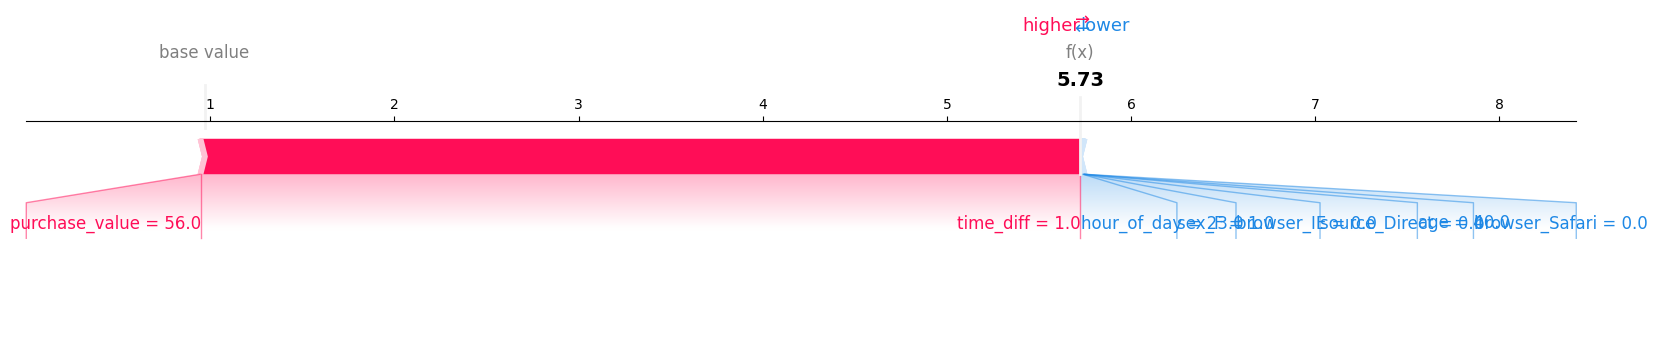


--- SHAP Analysis: False Negative (Row 2) ---


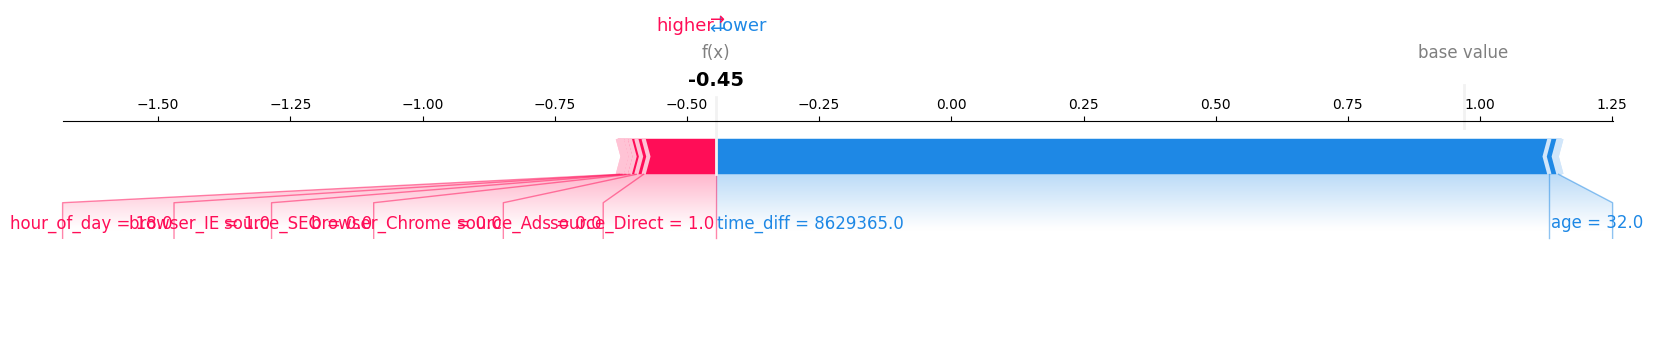

In [8]:
# Initialize JS for SHAP
shap.initjs()

# Choose the 'fraud' class (index 1)
sv = shap_values[1] if isinstance(shap_values, list) else shap_values
ev = explainer.expected_value[1] if isinstance(shap_values, list) else explainer.expected_value

# Plot 1: True Positive (The fraud we caught)
print(f"--- SHAP Analysis: True Positive (Row {tp_idx}) ---")
shap.force_plot(ev, sv[tp_idx,:], X_test.iloc[tp_idx,:], matplotlib=True)
plt.show()

# Plot 2: False Negative (The fraud we missed)
print(f"\n--- SHAP Analysis: False Negative (Row {fn_idx}) ---")
shap.force_plot(ev, sv[fn_idx,:], X_test.iloc[fn_idx,:], matplotlib=True)
plt.show()

In [ ]:
A detailed analysis of False Positives (legitimate users flagged as fraud) was conducted. 
Interestingly, the LightGBM model produced zero False Positives on the test set. 
This indicates the model is highly conservative and reliable. 
For the business, this means zero 'customer friction'—no innocent customers had their cards declined during this test phase